In [83]:
import os
import yfinance as yf
import pandas as pd
import datetime as dt
from pandas.tseries.offsets import MonthEnd
import feather
import pyarrow.parquet as pq
import pyarrow as pa


In [77]:
df = pd.read_csv('sp100.csv')
tickers =  [i.replace('.','-') for i in df.Symbol.to_list()]

file = 'datasets/sp100.parquet'
if not os.path.isfile(file):
    df = yf.download(tickers,start='2005-01-01')
    df.to_parquet('datasets/sp100.parquet')
df = pd.read_parquet('datasets/sp100.parquet')
df

Adj Close                                                  \
                  AAPL        ABBV         ABT         ACN        ADBE   
Date                                                                     
2005-01-03    0.971844         NaN   14.956534   19.618639   30.838949   
2005-01-04    0.981825         NaN   14.805904   19.157375   30.024111   
2005-01-05    0.990424         NaN   14.636057   19.082981   29.859142   
2005-01-06    0.991192         NaN   14.966144   18.911869   29.364239   
2005-01-07    1.063362         NaN   15.222524   19.797201   29.384233   
...                ...         ...         ...         ...         ...   
2021-07-21  145.399994  116.989998  118.980003  313.769989  612.260010   
2021-07-22  146.800003  117.540001  118.250000  314.260010  623.679993   
2021-07-23  148.559998  118.190002  120.800003  318.649994  625.869995   
2021-07-26  148.990005  117.790001  119.519997  318.980011  620.799988   
2021-07-27  146.770004  117.959999  119.809998  319.890015  618.280029   

                                                                         ...  \
                   AIG        AMGN         AMT         AMZN        AVGO  ...   
Date                                                                     ...   
2005-01-03  873.705200   50.510906   15.225256    44.520000         NaN  ...   
2005-01-04  876.616089   49.709389   15.024044    42.139999         NaN  ...   
2005-01-05  891.171082   48.923599   14.889898    41.770000         NaN  ...   
2005-01-06  892.627014   49.379353   15.024044    41.049999         NaN  ...   
2005-01-07  894.214600   49.481529   15.292330    42.320000         NaN  ...   
...                ...         ...         ...          ...         ...  ...   
2021-07-21   48.290001  244.850006  280.260010  3585.199951  479.019989  ...   
2021-07-22   47.560001  244.740005  281.600006  3638.030029  476.329987  ...   
2021-07-23   47.310001  247.720001  285.260010  3656.639893  483.149994  ...   
2021-07-26   47.709999  245.080002  284.609985  3699.820068  482.239990  ...   
2021-07-27   47.419998  244.679993  286.880005  3626.389893  475.359985  ...   

             Volume                                                    \
                UNH      UNP       UPS      USB           V        VZ   
Date                                                                    
2005-01-03  6252600  7762400   2176500  5374600         NaN   9236061   
2005-01-04  5582000  8108400   3127400  4552700         NaN  11680234   
2005-01-05  4577600  5504800   2130700  5701600         NaN   8201616   
2005-01-06  4837600  5653600   1773600  4203000         NaN   7844458   
2005-01-07  6653200  3998000   2396900  5312700         NaN   8424450   
...             ...      ...       ...      ...         ...       ...   
2021-07-21  1863700  2320000   1770900  5544800  11241400.0  25264100   
2021-07-22  1421900  4194900   1629700  4042900  10293600.0  16231400   
2021-07-23  1611700  3946800   2188900  3570500   6762000.0  14874700   
2021-07-26  2232600  2840900   2669400  3721300   4875500.0  15328200   
2021-07-27  2630200  3199000  13695700  4332400   7034000.0  15224600   

                                                   
                WBA       WFC       WMT       XOM  
Date                                               
2005-01-03  9757800   8168200  16078400  16009200  
2005-01-04  6618200   9241400  10596700  16718000  
2005-01-05  6850200   7694600   8241500  12189100  
2005-01-06  4816400   8887600  14028800  13098700  
2005-01-07  2946400   6573200   9660300  11315300  
...             ...       ...       ...       ...  
2021-07-21  8544400  29654600   6197300  20908700  
2021-07-22  3519000  23309500   4337800  13493800  
2021-07-23  3742600  23944700   5314100  14081500  
2021-07-26  4055900  22945100   6171000  18374900  
2021-07-27  5119100  22117000   5130200  16846000  

[4170 rows x 606 columns]

In [84]:
prices = df['Adj Close']
prices.index = pd.to_datetime(prices.index)
monthly_rets = prices.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)

In [85]:
formation_dt = dt.datetime(2009,2,28)
prior_monthly_rets = monthly_rets.loc[formation_dt -MonthEnd(1)]
prior_monthly_rets.name = 'monthly_rets'
prior_monthly_rets

AAPL    0.056005
ABBV    0.000000
ABT     0.046310
ACN    -0.037511
ADBE   -0.093001
          ...   
VZ     -0.106012
WBA     0.111066
WFC    -0.358888
WMT    -0.159472
XOM    -0.041964
Name: monthly_rets, Length: 101, dtype: float64

In [86]:
prior_monthly_rets = pd.DataFrame(prior_monthly_rets)
# Bucket returns
prior_monthly_rets['decile'] = pd.qcut(prior_monthly_rets.monthly_rets, 10, labels=False)
prior_monthly_rets

,monthly_rets,decile
AAPL,0.056005,8
ABBV,0.000000,7
ABT,0.046310,8
ACN,-0.037511,5
ADBE,-0.093001,3
...,...,...
VZ,-0.106012,2
WBA,0.111066,9
WFC,-0.358888,0
WMT,-0.159472,1


In [87]:
losers = prior_monthly_rets[prior_monthly_rets.decile == 0].index
losers_ret = monthly_rets.loc[formation_dt, monthly_rets.columns.isin(losers)].mean()
losers_ret

-0.2571558902685344

In [143]:
def monthly_decile(formation_dt, decile, monthly_rets):
    df = monthly_rets.loc[formation_dt - MonthEnd(1)].copy()
    df.name = 'monthly_rets'
    df = pd.DataFrame(df)
    df['decile'] = pd.qcut(df.monthly_rets, 10, labels=False,duplicates='drop')
    symbols = df[df.decile == decile].index
    decile_ret = monthly_rets.loc[formation_dt, monthly_rets.columns.isin(symbols)].mean()
    return decile_ret, symbols.values.tolist()

import datetime as dt
start_dt = dt.datetime(2021,1,1)
for i in range(1,8): 
    formation_dt = start_dt + MonthEnd(i)
    ret, symbols = monthly_decile(formation_dt, 9, monthly_rets)
    print(f'{formation_dt}: ret={ret*100:2.2f}% symbols={symbols[:10]}')


2021-01-31 00:00:00: ret=3.28% symbols=['AAPL', 'C', 'COF', 'DD', 'DIS', 'GS', 'LLY', 'ORCL', 'PM', 'TSLA']
2021-02-28 00:00:00: ret=-2.11% symbols=['ABT', 'BIIB', 'DD', 'F', 'GILD', 'GM', 'INTC', 'LLY', 'TSLA', 'WBA']
2021-03-31 00:00:00: ret=3.86% symbols=['BKNG', 'CAT', 'COP', 'CVX', 'GE', 'GS', 'MET', 'SPG', 'WFC', 'XOM']
2021-04-30 00:00:00: ret=1.02% symbols=['BA', 'CSCO', 'DUK', 'EXC', 'FB', 'HD', 'LIN', 'LOW', 'MO', 'WBA']
2021-05-31 00:00:00: ret=1.79% symbols=['AMZN', 'COF', 'DHR', 'FB', 'GOOG', 'GOOGL', 'MDT', 'NVDA', 'UPS', 'WFC']
2021-06-30 00:00:00: ret=-0.52% symbols=['AIG', 'C', 'COP', 'CVS', 'DD', 'DOW', 'F', 'LLY', 'MS', 'TGT']
2021-07-31 00:00:00: ret=1.48% symbols=['AAPL', 'ADBE', 'BIIB', 'COP', 'LLY', 'MSFT', 'NKE', 'NVDA', 'PYPL', 'TSLA']


In [127]:
returns = []
dates = monthly_rets[2:].index

for dt in dates:
    decile_returns = []
    returns.append(decile_returns)
    for decile in range(0,10):
        decile_returns.append(monthly_decile(dt, decile, monthly_rets)[0])

df = pd.DataFrame(returns)
df.index = dates
print(df.tail())
df.describe()

                   0         1         2         3         4         5  \
Date                                                                     
2021-03-31  0.049651  0.104434  0.058274  0.063344  0.066913  0.062120   
2021-04-30  0.041486  0.066699  0.063137  0.013477  0.039331  0.035424   
2021-05-31  0.056212  0.044504  0.026853  0.041550  0.024581  0.020993   
2021-06-30  0.018880  0.042987  0.041203  0.017282  0.006323  0.014800   
2021-07-31 -0.013868  0.004191  0.016292  0.038518  0.000252  0.035016   

                   6         7         8         9  
Date                                                
2021-03-31  0.081870  0.039691  0.060374  0.038632  
2021-04-30  0.062642  0.013503  0.045336  0.010193  
2021-05-31 -0.003612  0.006671  0.036492  0.017896  
2021-06-30 -0.008673 -0.020865 -0.000758 -0.005161  
2021-07-31 -0.007898  0.054968  0.018104  0.014786  


,0,1,2,3,4,5,6,7,8,9
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,186.000000
mean,0.013746,0.012182,0.014343,0.011875,0.010951,0.010760,0.012131,0.013397,0.010887,0.016620
std,0.066310,0.051284,0.045912,0.043680,0.043890,0.044789,0.041136,0.041954,0.044315,0.055601
min,-0.257156,-0.178518,-0.139985,-0.158907,-0.170001,-0.118507,-0.118499,-0.118595,-0.182748,-0.219621
25%,-0.009985,-0.009778,-0.006134,-0.010729,-0.007690,-0.008262,-0.008673,-0.010761,-0.013789,-0.008905
50%,0.015704,0.014985,0.012807,0.013419,0.014571,0.015472,0.017352,0.012095,0.012251,0.012981
75%,0.046138,0.039220,0.041203,0.038518,0.033052,0.035265,0.035339,0.039466,0.042141,0.042308
max,0.351954,0.178142,0.164705,0.121849,0.135560,0.131130,0.153876,0.180717,0.167735,0.328709


RangeIndex(start=0, stop=10, step=1)


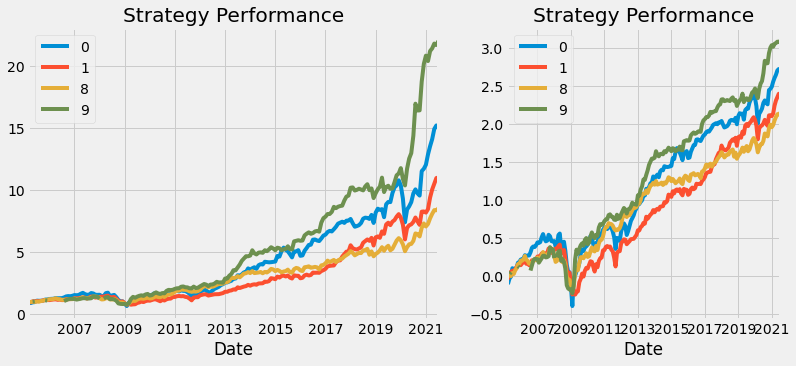

In [152]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
print(df.columns)
subplots_ratio = dict(width_ratios=[3,2], height_ratios=[1])

xdf = pd.read_csv('wip.csv', index_col='Date', parse_dates=True)

fig, ax = plt.subplots(1,2, gridspec_kw=subplots_ratio, figsize=(12,5))
xdf[list('0189')].cumsum().apply(np.exp).plot(title='Strategy Performance',ax=ax[0])
xdf[list('0189')].cumsum().plot(title='Strategy Performance',ax=ax[1])
#df.plot.hist(title='Returns Distribution', ax=ax[1], grid=True, bins=30)
#df.plot
plt.show()

In [66]:
#spy = yf.download('SPY',start='2005-01-01')
#spy = spy['Adj Close']
spy_rets = spy.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)
df['spy_rets']  = spy_rets[2:].values
df.describe()


,returns,spy_rets
count,197.000000,197.000000
mean,0.013746,0.009140
std,0.066310,0.042181
min,-0.257156,-0.165187
25%,-0.009985,-0.013344
50%,0.015704,0.013567
75%,0.046138,0.032415
max,0.351954,0.126984


In [73]:
xdf = prior_monthly_rets.groupby('decile')
xdf.describe()
#prior_monthly_rets
#[prior_monthly_rets.decile == 0].indexdf.groupby('')

monthly_rets                                                    \
              count      mean       std       min       25%       50%   
decile                                                                  
0              11.0 -0.334812  0.125874 -0.532671 -0.438158 -0.301929   
1              10.0 -0.171252  0.015387 -0.188967 -0.182819 -0.176291   
2              10.0 -0.117766  0.011827 -0.142285 -0.122674 -0.116400   
3              10.0 -0.087950  0.004371 -0.096438 -0.090024 -0.087128   
4              10.0 -0.071277  0.008562 -0.082433 -0.079634 -0.068529   
5              10.0 -0.048008  0.006540 -0.059104 -0.050625 -0.047893   
6              10.0 -0.020170  0.011303 -0.035768 -0.028566 -0.019566   
7              11.0 -0.000248  0.000645 -0.002114  0.000000  0.000000   
8               9.0  0.037803  0.016308  0.009327  0.024240  0.044693   
9              10.0  0.126481  0.068034  0.065038  0.091316  0.100374   

                            
             75%       max  
decile                      
0      -0.230819 -0.191041  
1      -0.161778 -0.146173  
2      -0.108157 -0.104664  
3      -0.084783 -0.082892  
4      -0.064837 -0.060855  
5      -0.043788 -0.037511  
6      -0.009480 -0.007235  
7       0.000000  0.000000  
8       0.048854  0.056005  
9       0.138044  0.278667